In [18]:
import os, sys
from joblib import dump, load
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
import pickle as pkl

sys.path.append(os.path.realpath('..'))

# reference: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [2]:
# load model
model = load('xgboost.model')

print(model.feature_importances_)

[0.00751923 0.01166547 0.00413593 0.00931981 0.01171992 0.03023642
 0.04308371 0.00210224 0.01220499 0.00067933 0.00245976 0.00566885
 0.00570283 0.00663551 0.00189258 0.05580073 0.09748626 0.00266397
 0.08322066 0.02683382 0.01502322 0.02036214 0.0442856  0.00756207
 0.01072461 0.00541286 0.0151673  0.00915235 0.01674618 0.01237106
 0.0071121  0.01544738 0.00953941 0.00752958 0.00223853 0.06887989
 0.00789806 0.01360189 0.01733267 0.02364842 0.03109241 0.01380125
 0.01808622 0.00277521 0.00598073 0.         0.02586451 0.02654053
 0.00402932 0.01225179 0.00975799 0.02632604 0.03236837 0.01494766
 0.         0.00052505 0.00051145 0.00360477 0.00529621 0.00068927
 0.00944188 0.00504207]


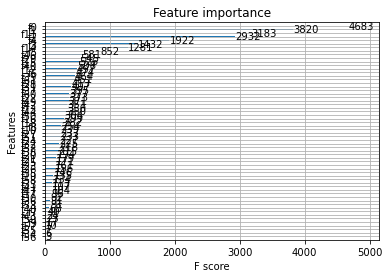

In [8]:
plot_importance(model)
pyplot.show() # too many features so the graph is ugly

In [23]:
# load original data
with open("../preprocess/processed_train.pkl", "rb") as f:
    global X, Y
    X, Y = pkl.load(f)
    
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=7)
# fit model
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
# print MSE
MSE = mean_squared_error(y_test, y_pred)
print("MSE: " + str(MSE))

MSE: 344.0584252112375


In [28]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBRegressor(subsample=1.0, reg_lambda=0.1, n_estimators=100, min_child_weight=10.0, max_depth=10, learning_rate=0.1, gamma=1.0, colsample_bytree=0.6, colsample_bylevel=0.6)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    _y_pred = [round(value) for value in y_pred]
    MSE = mean_squared_error(y_test, _y_pred)
    print("Thresh=%.3f, Number of features=%d, MSE: %.2f" % (thresh, select_X_train.shape[1], MSE))

Thresh=0.000, Number of features=62, MSE: 344.22
Thresh=0.000, Number of features=62, MSE: 344.22
Thresh=0.000, Number of features=60, MSE: 338.59
Thresh=0.001, Number of features=59, MSE: 342.02
Thresh=0.001, Number of features=58, MSE: 345.76
Thresh=0.001, Number of features=57, MSE: 346.77
Thresh=0.001, Number of features=56, MSE: 347.64
Thresh=0.002, Number of features=55, MSE: 345.96
Thresh=0.003, Number of features=54, MSE: 342.29
Thresh=0.003, Number of features=53, MSE: 348.53
Thresh=0.003, Number of features=52, MSE: 346.73
Thresh=0.003, Number of features=51, MSE: 346.45
Thresh=0.004, Number of features=50, MSE: 345.26
Thresh=0.005, Number of features=49, MSE: 355.74
Thresh=0.005, Number of features=48, MSE: 359.07
Thresh=0.005, Number of features=47, MSE: 358.26
Thresh=0.005, Number of features=46, MSE: 357.90
Thresh=0.006, Number of features=45, MSE: 362.41
Thresh=0.006, Number of features=44, MSE: 359.54
Thresh=0.006, Number of features=43, MSE: 354.41
Thresh=0.006, Number

In [ ]:
# from the above, we can see that reducing the number of features does not help
# Now we try PCA

# PCA

In [39]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [50]:
def train_with_pca(n_component):
    pca = PCA(n_components=n_component,svd_solver='full')
    X_pca = pca.fit_transform(X)

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.25, random_state=7)
    # fit model
    model.fit(X_train, y_train)
    # make predictions for test data and evaluate
    y_pred = model.predict(X_test)
    # print MSE
    MSE = mean_squared_error(y_test, y_pred)
    return MSE

In [51]:
for i in range(1, 60, 5):
    MSE = train_with_pca(i)
    print("PCA n_components = " + str(i) + ", MSE: " + str(MSE))

PCA n_components = 1, MSE: 2165.1316476700968
PCA n_components = 6, MSE: 1323.8076764343532
PCA n_components = 11, MSE: 934.6171542372174
PCA n_components = 16, MSE: 869.0585309134864
PCA n_components = 21, MSE: 742.3221815951841
PCA n_components = 26, MSE: 578.3900331061467
PCA n_components = 31, MSE: 557.2313534395499
PCA n_components = 36, MSE: 547.720541706174
PCA n_components = 41, MSE: 499.48788697285534
PCA n_components = 46, MSE: 498.43619606642505
PCA n_components = 51, MSE: 496.7207267320627
PCA n_components = 56, MSE: 484.47887994808787
